In [4]:
alpha = 1
beta = 5

class Ant:
    
    def __init__(self, starting_point, distances_matrix, points, pheromone_matrix):
        self.path = []
        self.starting_point = starting_point
        self.tour = 0
        self.current_point = starting_point
        self.distances_matrix = distances_matrix
        self.points = points
        self.pheromone_matrix = pheromone_matrix
        self.path_edges = []
        
    def decide_next_point(self, adjacent_points):
        
        if len(self.path) == 0:
            self.path.append(self.starting_point)
            
        possible_adjacent_points = [k for k in adjacent_points if not(k in self.path) ]
        
        if (self.starting_point in adjacent_points) and (len(self.path) == (len(self.points))):
            possible_adjacent_points.append(self.starting_point)
                
        probabilities = [probability_to_go_to_point(self.current_point, k, possible_adjacent_points, alpha, beta, self.pheromone_matrix, self.points, self.distances_matrix) for k in possible_adjacent_points]
                      
        best_point = possible_adjacent_points[probabilities.index(max(probabilities))] 
        
        self.path.append(best_point)
        
        self.path_edges.append(self.current_point + " " + best_point)
          
        self.tour += self.distances_matrix[self.points.index(self.current_point)][self.points.index(best_point)]
        
        self.current_point = best_point
        
    
def pheromone_deposed(ant, q = 1):
    return q / ant.tour

def dist(pt1, pt2, distances_matrix, points):
    return distances_matrix[points.index(pt1)][points.index(pt2)]

def edge_cost(pt1, pt2, distances_matrix, points):
    return 1 / dist(pt1, pt2, distances_matrix, points)

def get_neighbors_of_point(pt, edges, points):
    neighbors_list = []
    for k in points:
        combination_1 = str(pt) + " " + str(k) 
        combination_2 = str(k) + " " + str(pt)
        if (combination_1 in edges) or (combination_2 in edges):
            neighbors_list.append(k)
    return neighbors_list

def probability_to_go_to_point(starting_point, destination_point, allowed_adjacent_points, alpha, beta, pheromone_matrix, points, distances_matrix):
    
    denominator = 0
    
    for k in allowed_adjacent_points: 
        denominator += (get_pheromone_on_edge(starting_point + " " + k, pheromone_matrix, points) ** alpha) * (edge_cost(starting_point, k, distances_matrix, points) ** beta) 
        
    return ((get_pheromone_on_edge(starting_point + " " + destination_point, pheromone_matrix, points) ** alpha) * (edge_cost(starting_point, destination_point, distances_matrix, points) ** beta)) / denominator 

def get_pheromone_on_edge(edge, pheromone_matrix, points):
    pt1, pt2 = edge.split(" ")[0], edge.split(" ")[1]
    return pheromone_matrix[points.index(pt1)][points.index(pt2)]  

def update_pheromone_matrix(points, pheromone_matrix, ants, pheromone_evaporation_rate = 0.2):
    sum_of_pheromones = [[0 for _ in range(len(points))] for _ in range(len(points))]
    pm = [[0 for _ in range(len(points))] for _ in range(len(points))]
    
    for i in range(len(sum_of_pheromones)):
        for j in range(len(sum_of_pheromones)):
            pt1, pt2 = points[i], points[j]
            for a in ants:
                e1, e2 = pt1 + " " + pt2, pt2 + " " + pt1
                if (e1 in a.path_edges) or (e2 in a.path_edges):
                    sum_of_pheromones[i][j] += pheromone_deposed(a)
   
  
    for i in range(len(pheromone_matrix)):
        for j in range(len(pheromone_matrix)):
            pm[i][j] = (pheromone_matrix[i][j] * (1 - pheromone_evaporation_rate)) + sum_of_pheromones[i][j]
    
    return pm

In [5]:
def print_distances_matrix(points, distances_matrix):
    
    str_matrix = [[str(distances_matrix[r][c]) for c in range(len(points))] for r in range(len(points))]

    string = "     " +   "  ".join(points) + "\n"
    
    for i in range(len(points)):
        string += str(points[i] + "   " + '  '.join(str_matrix[i]) + "\n")
    
    print(string)
    

import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(points, edges, distances_matrix):
    graph = nx.Graph()    
    for e in edges:
        graph.add_edge(e.split(" ")[0], e.split(" ")[1], weight=distances_matrix[points.index(e.split(" ")[0])][points.index(e.split(" ")[1])])
       
    options = {
        "font_size": 8,
        "node_size": 300,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 2,
        "width": 3,
    }
    
    pos = nx.shell_layout(graph)
    nx.draw_networkx(graph,pos=pos, **options, with_labels=True)
    labels = nx.get_edge_attributes(graph,'weight')
    nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=labels, font_size=8)
    ax = plt.gca()
    ax.margins(0.05)
    plt.axis("on")
    plt.show()
    
def draw_graph_with_highlited_path(points, edges, distances_matrix, best_path):
    graph = nx.Graph()
        
    for e in edges:
        p1, p2 = e.split(" ")[0], e.split(" ")[1]
        if not (((p1 + " " + p2) in best_path) or ((p2 + " " + p1) in best_path)):
            graph.add_edge(e.split(" ")[0], e.split(" ")[1], weight=distances_matrix[points.index(e.split(" ")[0])][points.index(e.split(" ")[1])], color="black")
    
    for h in best_path:
        graph.add_edge(h.split(" ")[0], h.split(" ")[1], weight=distances_matrix[points.index(h.split(" ")[0])][points.index(h.split(" ")[1])], color="g")

    
    options = {
        "font_size": 8,
        "node_size": 300,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 3,
        "width": 3,
    }
    
    # pos=nx.spring_layout(graph, seed=241)
    # plt.figure(1, figsize=(50, 30), dpi=100)
    pos = nx.circular_layout(graph)
    # nx.draw_networkx(graph,pos=pos, **options, with_labels=True)
    colors = nx.get_edge_attributes(graph,'color').values()
    nx.draw(graph, pos, edge_color=colors, with_labels=True, **options)
    
    labels = nx.get_edge_attributes(graph,'weight')
    nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=labels, font_size=8)
    ax = plt.gca()
    ax.margins(0.05)
    plt.axis("on")
    plt.show()

# draw_graph(points = ["a", "b", "c", "d", "e"], edges = edges, distances_matrix = [[15, 20, 12, 0, 45], [12, 0, 0, 22, 45], [13, 0, 14, 25, 45], [13, 0, 14, 25, 45], [12, 0, 0, 22, 45]])

In [ ]:
def prepare_graph(n):
    
    points = ["P" + str(i + 1) for i in range(n)]
    
    distances_matrix = [[0 for _ in range(n)] for _ in range(n)]
    
    pheromone_matrix = [[1 for _ in range(n)] for _ in range(n)]
    
    edges = []
    
    for i in range(n):
        for j in range(n):
            if i == j: continue
            elif distances_matrix[i][j] != 0: continue 
            distances_matrix[i][j] = distances_matrix[j][i] = random.randint(20, 100)
            case1, case2 = points[i] + " " + points[j], points[j] + " " + points[i] 
            if not ((case1 in edges) or (case2 in edges)):
                edges.append(case1) 
          
    return {
        "points": points,
        "distances_matrix": distances_matrix,
        "pheromone_matrix": pheromone_matrix,
        "edges": edges 
    }
    
    
ng = 100
var = prepare_graph(ng)

import pickle

pickle.dump(var, open("data-" + str(ng), "wb"))

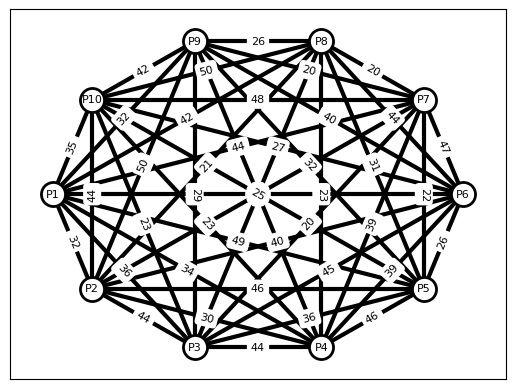

     P1  P2  P3  P4  P5  P6  P7  P8  P9  P10
P1   0  32  36  34  49  22  44  42  32  35
P2   32  0  44  30  46  40  38  21  50  44
P3   36  44  0  44  36  45  20  47  29  23
P4   34  30  44  0  46  39  39  23  41  23
P5   49  46  36  46  0  26  22  31  32  25
P6   22  40  45  39  26  0  47  44  40  27
P7   44  38  20  39  22  47  0  20  20  48
P8   42  21  47  23  31  44  20  0  26  50
P9   32  50  29  41  32  40  20  26  0  42
P10   35  44  23  23  25  27  48  50  42  0

tours values are: [262, 271, 248, 282, 258, 260, 242, 254, 242, 270]
the tour values did not change
tours values are: [262, 271, 248, 260, 258, 260, 242, 254, 242, 270]
the tour values changed!
tours values are: [262, 271, 248, 260, 258, 260, 242, 254, 242, 270]
the tour values did not change
tours values are: [262, 271, 248, 260, 258, 260, 242, 254, 242, 270]
the tour values did not change
tours values are: [262, 271, 248, 260, 258, 260, 242, 254, 242, 270]
the tour values did not change
tours values are: [262, 271, 

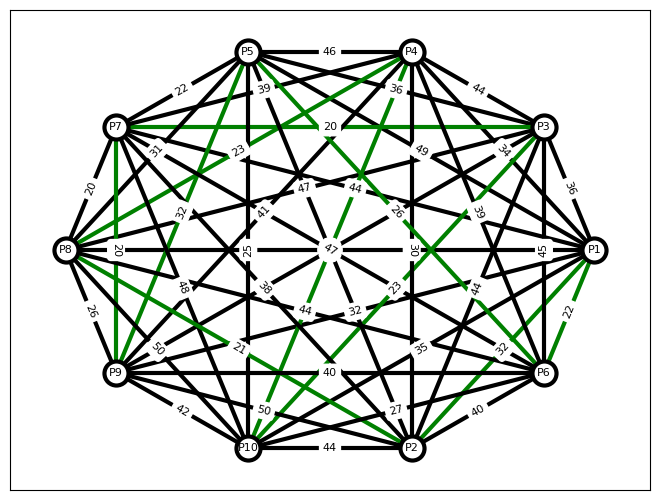

In [11]:
import numpy as np
import pickle

def get_most_used_path(pheromone_matrix, points):
    
    best_path = []
    
    for r in pheromone_matrix:
        max_pheromone_index = r.index(max(r))
        best_path.append(points[pheromone_matrix.index(r)] + " " + points[max_pheromone_index])
        
    return best_path
        

def same_path_for_all(ants):
    
    path_edges = ants[0].path_edges
    
    for e in path_edges:
        if not edge_in_all_ants_paths(e, ants):
            return False
    return True
        

def edge_in_all_ants_paths(edge, ants):
    for a in ants:
        pt1, pt2 = edge.split(" ")[0], edge.split(" ")[1]
        if not(((pt1 + " " + pt2) in a.path_edges) or ((pt2 + " " + pt1) in a.path_edges)):
            return False
    return True

import random

def min_tour_acheived(ants, smallest_tour):
    for a in ants:
        if a.tour != smallest_tour: return False
    return True

var = pickle.load(open("data-10", "rb"))

points = var["points"]
edges = var["edges"]

distances_matrix = var["distances_matrix"]

pheromone_matrix = var["pheromone_matrix"]

draw_graph(points, edges, distances_matrix)

ants = [Ant(points[t], distances_matrix, points, pheromone_matrix) for t in range(10)]

tours = []

best_path_edges = []

smallest_tour = 0
print_distances_matrix(points, distances_matrix)

for a in ants:
    while len(a.path_edges) != len(a.points):
        a.decide_next_point(get_neighbors_of_point(a.current_point, edges, points))
    tours.append(a.tour)

best_path_edges = ants[tours.index(min(tours))].path_edges
smallest_tour = tours[tours.index(min(tours))]

previous_tours = tours.copy()

stagnation_count = 10

counter = 0
while (not same_path_for_all(ants)) and counter < stagnation_count:
    for a in ants:
        a.path.clear()
        a.tour = 0
        a.path_edges.clear()
        a.current_point = a.starting_point
    tours.clear()
    for a in ants:
        while len(a.path_edges) != len(a.points):
            a.decide_next_point(get_neighbors_of_point(a.current_point, edges, points))
        tours.append(a.tour)
    print("tours values are:", tours)
    
    if tours == previous_tours:
        print('the tour values did not change') 
        counter += 1
    
    else:
        print('the tour values changed!')
        counter = 0
        previous_tours = tours.copy()
    
    if(min(tours) < smallest_tour):
        best_path_edges = ants[tours.index(min(tours))].path_edges
        smallest_tour = tours[tours.index(min(tours))]
    
    pheromone_matrix = update_pheromone_matrix(points, pheromone_matrix, ants)
    for a in ants:
        a.pheromone_matrix = pheromone_matrix
        
print("----------------------------------------")    
# print("done, and the optimal path found is: ", ants[tours.index(min(tours))].path_edges)
# print("done, and the optimal tour value is: ", ants[tours.index(min(tours))].tour)
print("done, and the optimal path found is: ", best_path_edges)
print("done, and the optimal tour value is: ", smallest_tour)

draw_graph_with_highlited_path(points, edges, distances_matrix, best_path_edges)


5  ---- > ['P3 P7', 'P7 P8', 'P8 P2', 'P2 P4', 'P4 P10', 'P10 P5', 'P5 P6', 'P6 P1', 'P1 P9', 'P9 P3']
5  ---- >  248
10  ---- > ['P7 P3', 'P3 P10', 'P10 P4', 'P4 P8', 'P8 P2', 'P2 P1', 'P1 P6', 'P6 P5', 'P5 P9', 'P9 P7']
10  ---- >  242


Text(0, 0.5, 'execution time (seconds)')

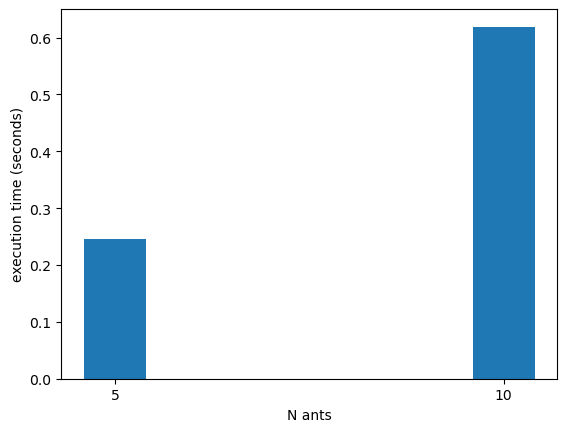

In [16]:
import time
import matplotlib.pyplot as plt

n_of_ants = [i * 5 for i in range(1, 3)]

execution_time = []

var = pickle.load(open("data-10", "rb"))

points = var["points"]
edges = var["edges"]

distances_matrix = var["distances_matrix"]

pheromone_matrix = var["pheromone_matrix"]

for ants_count in n_of_ants:
    ants = [Ant(points[t], distances_matrix, points, pheromone_matrix) for t in range(ants_count)]

    tours = []

    best_path_edges = []

    smallest_tour = 0
    
    start_time = time.time()
    
    for a in ants:
        while len(a.path_edges) != len(a.points):
            a.decide_next_point(get_neighbors_of_point(a.current_point, edges, points))
        tours.append(a.tour)
        
    best_path_edges = ants[tours.index(min(tours))].path_edges
    smallest_tour = tours[tours.index(min(tours))]    

    previous_tours = tours.copy()

    stagnation_count = 10

    counter = 0
    
    while (not same_path_for_all(ants)) and counter < stagnation_count:
        for a in ants:
            a.path.clear()
            a.tour = 0
            a.path_edges.clear()
            a.current_point = a.starting_point
        tours.clear()
        for a in ants:
            while len(a.path_edges) != len(a.points):
                a.decide_next_point(get_neighbors_of_point(a.current_point, edges, points))
            tours.append(a.tour)
        
        if tours == previous_tours:
            counter += 1
        
        else:
            counter = 0
            previous_tours = tours.copy()
            
        if(min(tours) < smallest_tour):
            best_path_edges = ants[tours.index(min(tours))].path_edges
            smallest_tour = tours[tours.index(min(tours))]            
    
        pheromone_matrix = update_pheromone_matrix(points, pheromone_matrix, ants)
        for a in ants:
            a.pheromone_matrix = pheromone_matrix
            
    # print("done, and the optimal path found is: ", ants[tours.index(min(tours))].path_edges)
    # print("done, and the optimal tour value is: ", ants[tours.index(min(tours))].tour)
    print(ants_count," ---- >", best_path_edges)
    print(ants_count, " ---- > ", smallest_tour)
    execution_time.append(time.time() - start_time)

plt.bar(n_of_ants, execution_time)
plt.xticks(n_of_ants)
plt.xlabel('N ants')
plt.ylabel('execution time (seconds)')
    